# Analytics with BigQuery

Let's chart the revenue per cohort using TPC-H datasets

## Setup environment

In [1]:
from IPython.display import HTML, display

import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# Set up featuremesh client to translate/run queries
from libs.helpers.utils_db import query_bigquery
from libs.helpers.utils import get_featuremesh_config

fm_config = get_featuremesh_config()

__ACCESS_TOKEN__ = fm_config['access_token']

import featuremesh
%reload_ext featuremesh

# Optional
featuremesh.set_default("registry.host", fm_config['registry.host'])
featuremesh.set_default("access.host", fm_config['access.host'])



client_duckdb = featuremesh.OfflineClient(
    access_token=__ACCESS_TOKEN__, 
    backend=featuremesh.Backend.BIGQUERY, 
    sql_executor=query_bigquery
)

featuremesh.set_default('client', client_duckdb)  # Allow to use %%featureql magic command without specifying the client

In [3]:
# Use this in case of problem with the token
# featuremesh.decode_token(__ACCESS_TOKEN__)

## TPC-H dataset in BigQuery

### Load data from DuckDB to BigQuery (run only once)

In [4]:
LOAD_DATA_IN_BIGQUERY = False

In [5]:
from google.cloud import bigquery
from libs.helpers.utils import get_bigquery_config
from libs.helpers.utils_db import query_duckdb as query_duckdb_direct

def query_duckdb(sql: str) -> pd.DataFrame:
    return query_duckdb_direct(sql, storage_path="/files/local1.db")  # You need to interrupt the kernel of notebooks that run the same connexion

if LOAD_DATA_IN_BIGQUERY:
    
    bq_client = bigquery.Client(project=get_bigquery_config()['project'])
    
    # Create dataset in BigQuery
    dataset_id = 'TPCH'
    dataset = bigquery.Dataset(f'{__YOUR_BIGQUERY_PROJECT__}.{dataset_id}')
    # dataset.location = 'US'
    
    try:
        bq_client.create_dataset(dataset, exists_ok=True)
        print(f"Dataset {dataset_id} created or already exists")
    except Exception as e:
        print(f"Error creating dataset: {e}")
    
    # TPC-H table names that we need
    tables = ['customer', 'customer_history', 'orders']
    
    # Load each table
    for table_name in tables:
        print(f"Loading {table_name}...")
        
        # Extract data from DuckDB
        df = query_duckdb(f"SELECT * FROM TPCH.{table_name}")
        
        print(f"  Rows: {len(df)}")
        
        # Load to BigQuery
        table_id = f'{__YOUR_BIGQUERY_PROJECT__}.{dataset_id}.{table_name.upper()}'
        
        job_config = bigquery.LoadJobConfig(
            write_disposition='WRITE_TRUNCATE',
            autodetect=True
        )
        
        job = bq_client.load_table_from_dataframe(df, table_id, job_config=job_config)
        job.result()
        
        print(f"  Loaded to {table_id}")
    
    print("Done!")

else:

    print("Skipped!")

Skipped!


### Read data

In [6]:
query_bigquery("SELECT * FROM TPCH.__TABLES__")

,project_id,dataset_id,table_id,creation_time,last_modified_time,row_count,size_bytes,type
0,mpaas-prod,TPCH,CUSTOMER,1762783606294,1762783606294,15000,2609857,1
1,mpaas-prod,TPCH,CUSTOMER_HISTORY,1762783612039,1762783612039,10000,4000000,1
2,mpaas-prod,TPCH,ORDERS,1762783620985,1762783620985,150000,18138616,1


In [7]:
query_bigquery("SELECT * FROM TPCH.CUSTOMER LIMIT 10")

,c_custkey,c_name,c_address,c_nationkey,c_phone,c_acctbal,c_mktsegment,c_comment
0,155,Customer#000000155,G0z8BKI8yeLN uBvI,0,10-566-282-8705,5902.85,AUTOMOBILE,the quickly unusual accounts. dependencies boost furiously bold foxes.
1,491,Customer#000000491,"AXsbcyMDujG,CAiEu4FmufbZ1k",0,10-856-259-7548,785.37,AUTOMOBILE,"ly final, even hockey players. carefully final ideas w"
2,823,Customer#000000823,kxCcxifuuT9S2naKMuLEj3,0,10-109-430-5638,738.79,AUTOMOBILE,ully regular ideas wake slyly regular foxes. unusual platelets eat furiously above the slyly
3,854,Customer#000000854,MF8909Fm3vv nOEYxMNLhZcIA1ORE1j,0,10-544-967-2382,3393.86,AUTOMOBILE,longside of the even theodolites boost across the slyly even dep
4,874,Customer#000000874,ANCrGEGkJyxBjUNQfGaCESaz hZsWfm6BQ5o7cDY,0,10-886-494-4217,5391.74,AUTOMOBILE,"ets. foxes about the regular, even hockey players was slyl"
5,895,Customer#000000895,"fnQh TMGk79TRP8UojSL,4K4b7",0,10-933-819-2037,904.43,AUTOMOBILE,y pending accounts sleep thinly. fluffily even packages a
6,896,Customer#000000896,8xZ1peKI8mgRdz,0,10-425-565-3199,7659.72,AUTOMOBILE,nts play blithely. packages affix. blithely spe
7,915,Customer#000000915,FykMsCZp9sPLb5F1Z0kS5F,0,10-452-398-2445,3776.53,AUTOMOBILE,"he even, bold instructions. quickly final foxes wake thinly care"
8,955,Customer#000000955,"miIz,OhJ9Vov5ofu",0,10-918-863-8880,138.31,AUTOMOBILE,fully ironic theodolites haggle blithely final ideas. evenly final foxes haggle
9,1283,Customer#000001283,"VhMf4nynm9cp0,gt4p0iV3zS i3qoSAtlxF5Vdbo",0,10-203-771-2219,2222.71,AUTOMOBILE,ironically ironic instructions. blithely silen


## Revenue per registration cohorts

### Self contained query

We define everything we need in the query, we don't use anything from the registry

In [8]:
%%featureql --hook output

/* SQL */ 
WITH 
base AS FEATUREQL/*
    
    WITH
        -- CUSTOMER ENTITY
        CUSTOMERS := ENTITY(),
        CUSTOMER_ID := INPUT(BIGINT#CUSTOMERS),

        SOURCE_CUSTOMER := EXTERNAL_SQL_QUERY(`SELECT AS STRUCT c_custkey as CUSTOMER_ID, c_mktsegment FROM TPCH.CUSTOMER WHERE c_custkey=%CUSTOMER_ID`),
        CUSTOMER_MKTSEGMENT := EXTERNAL_SQL_EXTRACT(c_mktsegment FROM SOURCE_CUSTOMER AS VARCHAR),

        SOURCE_CUSTOMER_HISTORY := EXTERNAL_SQL_QUERY(`SELECT AS STRUCT h_custkey as CUSTOMER_ID, h_datefirstorder FROM TPCH.CUSTOMER_HISTORY WHERE h_custkey=%CUSTOMER_ID`),
        CUSTOMER_DATEFIRST := EXTERNAL_SQL_EXTRACT(h_datefirstorder FROM SOURCE_CUSTOMER_HISTORY AS DATE),

        -- ORDER ENTITY
        ORDERS := ENTITY(),
        ORDER_ID := INPUT(BIGINT#ORDERS),

        SOURCE_ORDER := EXTERNAL_SQL_QUERY(`SELECT AS STRUCT o_orderkey AS ORDER_ID, o_custkey, o_orderdate, o_totalprice FROM TPCH.ORDERS WHERE o_orderkey=%ORDER_ID`),
        ORDER_CUSTOMER_ID := EXTERNAL_SQL_EXTRACT(o_custkey FROM SOURCE_ORDER AS BIGINT#CUSTOMERS),
        ORDER_DATE := EXTERNAL_SQL_EXTRACT(o_orderdate FROM SOURCE_ORDER AS DATE),
        ORDER_TOTALPRICE := EXTERNAL_SQL_EXTRACT(o_totalprice FROM SOURCE_ORDER AS DOUBLE),

        CUSTOMER_DATA := ADD_FIELDS(
            CUSTOMER_DATEFIRST AS date_first
            TO ROW(ORDER_CUSTOMER_ID as customer_id) 
            -- BINDING FIELDS customer_id WITH CUSTOMER_ID
        ),
        ORDER_ID := BIND_SQL(SELECT o_orderkey AS ORDER_ID FROM TPCH.ORDERS),
        -- ORDER_ID := BIND_KEYS(ALL ORDERS),
    SELECT 
        date_format(CAST(ORDER_DATE AS TIMESTAMP), '%Y') as REVENUE_MONTH,
        date_format(CAST(CUSTOMER_DATA[date_first] AS TIMESTAMP), '%Y') as COHORT,
        ORDER_TOTALPRICE AS REVENUE,
                                          
*/
SELECT REVENUE_MONTH, COHORT, SUM(REVENUE) as REVENUE_GROUPED
FROM base
GROUP BY 1,2
ORDER BY 1,2

INFO: The output has been stored as a dict in variable 'output'


,REVENUE_MONTH,COHORT,REVENUE_GROUPED
0,1992,1992,3.249822e+09
1,1993,1992,2.869991e+09
2,1993,1993,3.166897e+08
3,1994,1992,2.944579e+09
4,1994,1993,2.718928e+08
5,1994,1994,5.991959e+07
6,1995,1992,2.937268e+09
7,1995,1993,2.676925e+08
8,1995,1994,5.267628e+07
9,1995,1995,1.225835e+07


mkdir -p failed for path /home/jovyan/.config/matplotlib: [Errno 13] Permission denied: '/home/jovyan/.config/matplotlib'


Matplotlib created a temporary cache directory at /tmp/matplotlib-e_6tz4dd because there was an issue with the default path (/home/jovyan/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


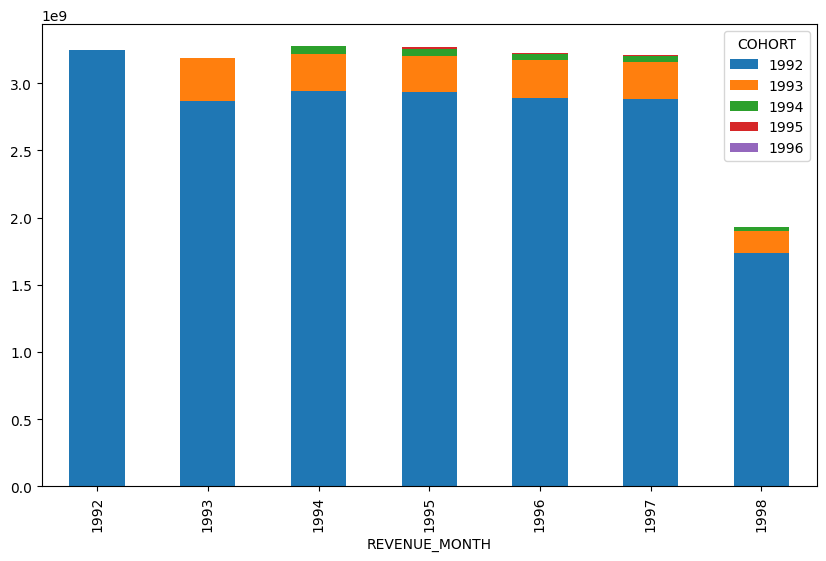

In [9]:
# !pip install matplotlib
# !pip install seaborn

df = output['dataframe']
pivot_df = df.pivot(index='REVENUE_MONTH', columns='COHORT', values='REVENUE_GROUPED')
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
None

### With persistence

In [10]:
%%featureql

DROP FEATURES IF EXISTS IN FM.DEMOS_BQ

,feature_name,status,message
0,FM.DEMOS_BQ.CUSTOMER_DATA,DELETED,Feature successfully deleted
1,FM.DEMOS_BQ.ORDER_TOTALPRICE,DELETED,Feature successfully deleted
2,FM.DEMOS_BQ.ORDER_DATE,DELETED,Feature successfully deleted
3,FM.DEMOS_BQ.ORDER_CUSTOMER_ID,DELETED,Feature successfully deleted
4,FM.DEMOS_BQ.SOURCE_ORDER,DELETED,Feature successfully deleted
5,FM.DEMOS_BQ.CUSTOMER_DATEFIRST,DELETED,Feature successfully deleted
6,FM.DEMOS_BQ.SOURCE_CUSTOMER_HISTORY,DELETED,Feature successfully deleted
7,FM.DEMOS_BQ.CUSTOMER_MKTSEGMENT,DELETED,Feature successfully deleted
8,FM.DEMOS_BQ.SOURCE_CUSTOMER,DELETED,Feature successfully deleted


#### Step 1: Data engineers would persist the sources

In [11]:
%%featureql

CREATE OR REPLACE FEATURES AS
SELECT
    -- CUSTOMER ENTITY
    FM.CORE.CUSTOMERS := ENTITY(),
    FM.CORE.CUSTOMER_ID := INPUT(BIGINT#FM.CORE.CUSTOMERS),

    -- ORDER ENTITY
    FM.CORE.ORDERS := ENTITY(),
    FM.CORE.ORDER_ID := INPUT(BIGINT#FM.CORE.ORDERS),
    
    -- EXTERNAL SOURCES AND MAPPINGS
    FM.DEMOS_BQ.SOURCE_CUSTOMER := EXTERNAL_SQL_QUERY(`SELECT AS STRUCT c_custkey as CUSTOMER_ID, c_mktsegment FROM TPCH.CUSTOMER WHERE c_custkey=%FM.CORE.CUSTOMER_ID`),
    FM.DEMOS_BQ.CUSTOMER_MKTSEGMENT := EXTERNAL_SQL_EXTRACT(c_mktsegment FROM FM.DEMOS_BQ.SOURCE_CUSTOMER AS VARCHAR),
    
    FM.DEMOS_BQ.SOURCE_CUSTOMER_HISTORY := EXTERNAL_SQL_QUERY(`SELECT AS STRUCT h_custkey as FM__CORE__CUSTOMER_ID, h_datefirstorder FROM TPCH.CUSTOMER_HISTORY WHERE h_custkey=%FM.CORE.CUSTOMER_ID`),
    FM.DEMOS_BQ.CUSTOMER_DATEFIRST := EXTERNAL_SQL_EXTRACT(h_datefirstorder FROM FM.DEMOS_BQ.SOURCE_CUSTOMER_HISTORY AS DATE),
    
    FM.DEMOS_BQ.SOURCE_ORDER := EXTERNAL_SQL_QUERY(`SELECT AS STRUCT o_orderkey AS FM__CORE__ORDER_ID, o_custkey, o_orderdate, o_totalprice FROM TPCH.ORDERS WHERE o_orderkey=%FM.CORE.ORDER_ID`),
    FM.DEMOS_BQ.ORDER_CUSTOMER_ID := EXTERNAL_SQL_EXTRACT(o_custkey FROM FM.DEMOS_BQ.SOURCE_ORDER AS BIGINT#FM.CORE.CUSTOMERS),
    FM.DEMOS_BQ.ORDER_DATE := EXTERNAL_SQL_EXTRACT(o_orderdate FROM FM.DEMOS_BQ.SOURCE_ORDER AS DATE),
    FM.DEMOS_BQ.ORDER_TOTALPRICE := EXTERNAL_SQL_EXTRACT(o_totalprice FROM FM.DEMOS_BQ.SOURCE_ORDER AS DOUBLE),
    
    -- THE "JOINED" DATA
    FM.DEMOS_BQ.CUSTOMER_DATA := ADD_FIELDS(
        FM.DEMOS_BQ.CUSTOMER_DATEFIRST AS date_first
        TO ROW(FM.DEMOS_BQ.ORDER_CUSTOMER_ID as customer_id) 
        BINDING FIELDS customer_id WITH FM.CORE.CUSTOMER_ID
    )

,feature_name,status,message
0,FM.CORE.CUSTOMERS,REPLACED,Feature was replaced
1,FM.CORE.CUSTOMER_ID,REPLACED,Feature was replaced
2,FM.CORE.ORDERS,REPLACED,Feature was replaced
3,FM.CORE.ORDER_ID,REPLACED,Feature was replaced
4,FM.DEMOS_BQ.SOURCE_CUSTOMER,CREATED,Feature created as not exists
5,FM.DEMOS_BQ.CUSTOMER_MKTSEGMENT,CREATED,Feature created as not exists
6,FM.DEMOS_BQ.SOURCE_CUSTOMER_HISTORY,CREATED,Feature created as not exists
7,FM.DEMOS_BQ.CUSTOMER_DATEFIRST,CREATED,Feature created as not exists
8,FM.DEMOS_BQ.SOURCE_ORDER,CREATED,Feature created as not exists
9,FM.DEMOS_BQ.ORDER_CUSTOMER_ID,CREATED,Feature created as not exists


#### Step 2: Analysts/Business would just have to consume it

In [12]:
%%featureql

SELECT 
    FM.CORE.CUSTOMER_ID := BIND_TABLE(ARRAY[1,2,3,4]),
    FM.DEMOS_BQ.CUSTOMER_MKTSEGMENT,
    FM.DEMOS_BQ.CUSTOMER_DATEFIRST

,FM__CORE__CUSTOMER_ID,FM__DEMOS_BQ__CUSTOMER_MKTSEGMENT,FM__DEMOS_BQ__CUSTOMER_DATEFIRST
0,1,BUILDING,1992-04-19
1,2,AUTOMOBILE,1992-12-07
2,3,AUTOMOBILE,NaT
3,4,MACHINERY,1992-06-09


#### Step 3: ...either directly

In [13]:
%%featureql --hide-dataframe --hook output1

WITH
    FM.CORE.ORDER_ID := BIND_SQL(SELECT o_orderkey as FM__CORE__ORDER_ID FROM tpch.orders),
    date_format(CAST(FM.DEMOS_BQ.ORDER_DATE AS TIMESTAMP), '%Y') as REVENUE_MONTH,
    date_format(CAST(FM.DEMOS_BQ.CUSTOMER_DATA[date_first] AS TIMESTAMP), '%Y') as COHORT,
    FM.DEMOS_BQ.ORDER_TOTALPRICE AS REVENUE
SELECT 
    REVENUE_MONTH, 
    COHORT, 
    SUM(REVENUE) GROUP BY REVENUE_MONTH, COHORT as REVENUE_GROUPED
ORDER BY REVENUE_MONTH, COHORT

INFO: The output has been stored as a dict in variable 'output1'


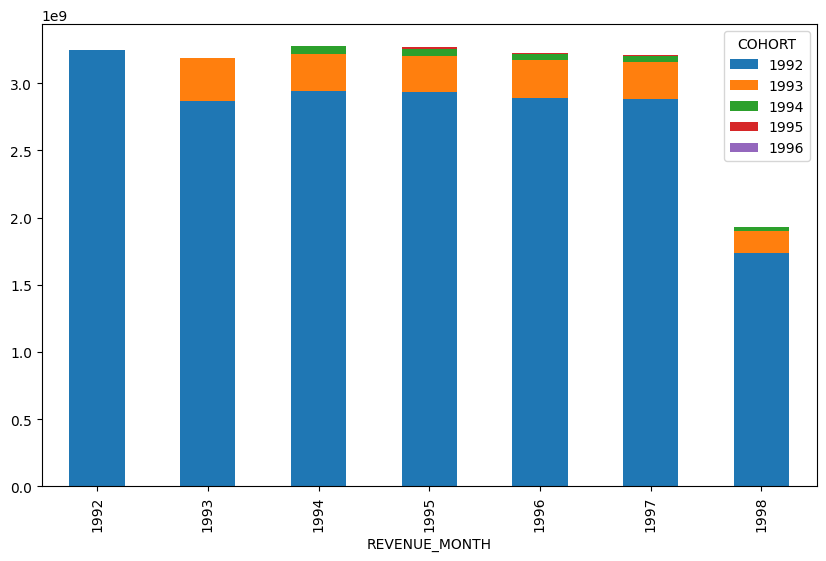

In [14]:
df = output1['dataframe']
pivot_df = df.pivot(index='REVENUE_MONTH', columns='COHORT', values='REVENUE_GROUPED')
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
None

#### Step 4: ...or possibly in an hybrid SQL/FeatureQL query
To use SQL generation capabilities of BI tools

In [15]:
%%featureql --hide-dataframe --hook output2

/* SQL */ 
SELECT REVENUE_MONTH, COHORT, SUM(REVENUE) as REVENUE_GROUPED
FROM FEATUREQL/*

    SELECT 
        FM.CORE.ORDER_ID := BIND_SQL(SELECT o_orderkey as FM__CORE__ORDER_ID FROM tpch.orders),
        date_format(CAST(FM.DEMOS_BQ.ORDER_DATE AS TIMESTAMP), '%Y') as REVENUE_MONTH,
        date_format(CAST(FM.DEMOS_BQ.CUSTOMER_DATA[date_first] AS TIMESTAMP), '%Y') as COHORT,
        FM.DEMOS_BQ.ORDER_TOTALPRICE AS REVENUE
    
*/
GROUP BY 1,2
ORDER BY 1,2

INFO: The output has been stored as a dict in variable 'output2'


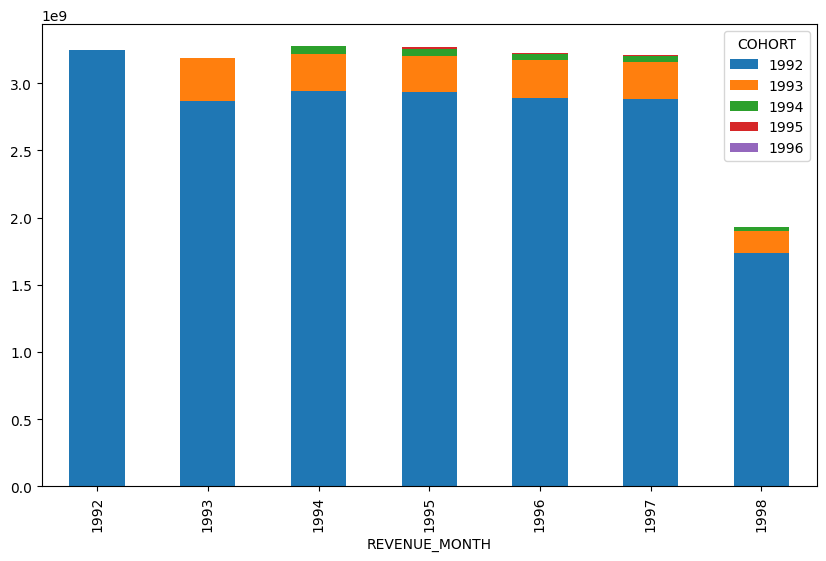

In [16]:
df = output2['dataframe']
pivot_df = df.pivot(index='REVENUE_MONTH', columns='COHORT', values='REVENUE_GROUPED')
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
None